In [1]:
import numpy as np,matplotlib.pyplot as plt,mne,os,sys,glob,numpy as np,torch
from mne.datasets import eegbci
from IPython.display import clear_output
from torch import nn
import torch.optim as optim
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal
import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.preprocessing import Xdawn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#X_syntheic = np.load("Synthetic_data_V2/X_subject_7_72_['left', 'right', 'foot', 'tongue'].npy")
#y_syntheic = np.load("Synthetic_data_V2/y_subject_7_72_['left', 'right', 'foot', 'tongue'].npy")


X_syntheic = np.load("Synthetic_data_online/X_subject_[20]_72_['left', 'right']_v2.npy")
y_syntheic = np.load("Synthetic_data_online/y_subject_[20]_72_['left', 'right']_v2.npy")

In [3]:
from mne.io import RawArray
freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (0, 0.5)  # baseline interval (in s)
tmin, tmax = 0, 7
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']


ch_names = ["Fz",
     'C3','Cz','C4',
        'Pz',
     'PO7','PO8',
        'Oz'
 ]

Not setting metadata
144 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


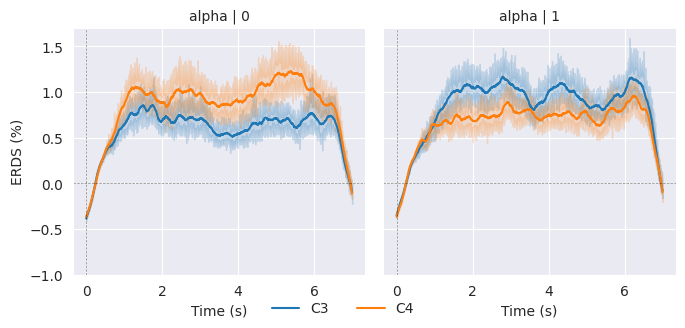

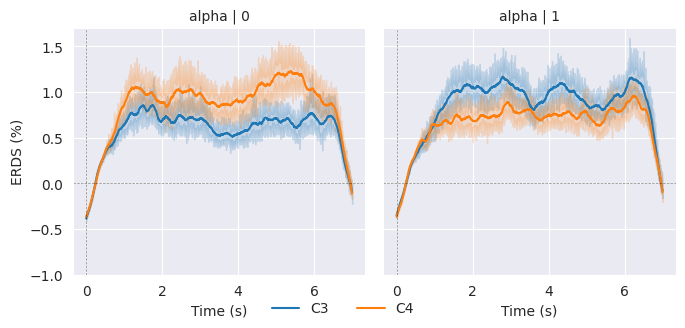

In [4]:
info = mne.create_info(ch_names=ch_names,sfreq = 250 ,ch_types ="eeg")
epochs = mne.EpochsArray(X_syntheic,info,baseline=baseline)
for i in range(y_syntheic.shape[0]):
    epochs.events[i][2] = y_syntheic[i]
epochs.event_id = {'0':0,'1':1}

epochs.pick_channels(["C3","C4"])
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,return_itc=False, average=False, decim=1)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])



df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

#g.savefig("ERD/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0]))
#g.savefig("unicorn/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0]))
g.fig#.clf()